# ML Assignment 2

Data set 1 - Bank Account Fraud Dataset \
https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022 \

In [5]:
# !pip install mlrose
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from sklearn.neural_network import MLPClassifier

import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
from datetime import datetime
import seaborn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statistics import mean
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import process_time
import itertools 

In [6]:
#load data
nrows = 5000
df = pd.read_csv('Base.csv', nrows = nrows)

# Functions

In [7]:
def train_valid_test_split(df, target = 'fraud_bool'):
    # split df to train set and test set
    from sklearn.model_selection import train_test_split
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, 
                                                        train_size = 0.8, random_state=0)
    
    
    # split train set to train set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify = y_train, 
                                                    train_size = 0.8, random_state=0)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [8]:
# knn impute numeric columns and one hot encode category columns
def ohe(X_train, X_valid, X_test):
    # impute numeric columns
    numcols = X_train.select_dtypes(include=['float','int']).columns
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    imputer.fit(X_train[numcols])
    X_train[numcols] = pd.DataFrame(imputer.transform(X_train[numcols]), columns=numcols)
    X_valid[numcols] = pd.DataFrame(imputer.transform(X_train[numcols]), columns=numcols)
    X_test[numcols] = pd.DataFrame(imputer.transform(X_train[numcols]), columns=numcols)
    
    # impute categorical columns
    ohe_training_predictors = pd.get_dummies(X_train)
    ohe_valid_predictors = pd.get_dummies(X_valid)
    ohe_test_predictors = pd.get_dummies(X_test)
    X_train, X_valid = ohe_training_predictors.align(
        ohe_valid_predictors,join='left', axis=1)

    X_train, X_test = ohe_training_predictors.align(
        ohe_test_predictors,join='left', axis=1)
    
    X_train=X_train.fillna(0)
    X_valid=X_valid.fillna(0)
    X_test=X_test.fillna(0)
    
    return X_train, X_valid, X_test

# X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)

In [9]:
def oversampling(X_train, y_train):
    # over-sampling: match the minority class to the majority class
    from collections import Counter
    from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)
    sampler = RandomOverSampler(sampling_strategy='auto',random_state=0)
    X_train_rs, y_train_rs = sampler.fit_resample(X_train, y_train)
#     print('Before resample {}'.format(Counter(y_train)),' RandomOverSampler {}'.format(Counter(y_train_rs)))
    
    return X_train_rs, y_train_rs

In [10]:
def model(model, X_train, y_train, X_valid, y_valid):
    t_start = process_time()
    model = model.fit(X_train, y_train)
    # predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_valid)
    t_stop = process_time()
    t = t_stop - t_start
    
    # calculate score
    from sklearn.metrics import roc_curve,roc_auc_score, auc, f1_score, accuracy_score, recall_score
    train_roc = roc_auc_score(y_train,train_pred)
    cv_score = cross_val_score(model, X_train, y_train, cv=5)
    test_roc = roc_auc_score(y_valid,test_pred)
    f1_score = f1_score(y_valid, test_pred, average='weighted')
    acc = accuracy_score(y_valid, test_pred)
    recall_score = recall_score(y_valid, test_pred, average='weighted')
    
    perf = pd.DataFrame({'acc':[round(acc,3)],
                         'cv_score':[round(mean(cv_score),3)],
                         'train_roc':[round(train_roc,3)],                
                         'test_roc':[round(test_roc,3)],
                         'recall_score':[round(recall_score,3)],
                         'f1_score':[round(f1_score,3)],
                         'run_time':[round(t,5)]
                        })
    return perf

# Modelling

In [11]:
'back propagation'
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model
mlp =  MLPClassifier(random_state = 0, 
                     hidden_layer_sizes=(3,), 
                     activation='identity')
mlp.fit(X_train, y_train)
nn_test_perf = model(mlp, X_train, y_train, X_test, y_test)
nn_test_perf['name'] = 'nn_backpropagation'
nn_test_perf

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,name
0,0.647,0.673,0.694,0.695,0.647,0.663,0.07812,nn_backpropagation


In [12]:
'''random hill climb'''
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model

mlp = mlrose.NeuralNetwork(random_state = 0, 
                           hidden_nodes = [3], 
                           activation = 'identity',
                           algorithm = 'random_hill_climb',
                           curve = True
                          )
# mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(100,), activation='relu')
mlp.fit(X_train, y_train)
nn_rhc = model(mlp, X_train, y_train, X_test, y_test)

nn_rhc['name'] = 'nn_rhc'
nn_rhc

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,name
0,0.581,0.472,0.407,0.407,0.581,0.525,0.15625,nn_rhc


In [12]:
# plt.plot(mlp.fitness_curve)

In [13]:
'''simulated annealing'''
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model

mlp = mlrose.NeuralNetwork(random_state = 0, 
                           hidden_nodes = [3], 
                           activation = 'identity',
                           algorithm = 'simulated_annealing',
                           curve = True
                          )
# mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(100,), activation='relu')
mlp.fit(X_train, y_train)
nn_sa = model(mlp, X_train, y_train, X_test, y_test)

nn_sa['name'] = 'nn_sa'
nn_sa

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,name
0,0.707,0.512,0.542,0.516,0.707,0.623,0.03125,nn_sa


In [14]:
# plt.plot(mlp.fitness_curve)

In [15]:
'''genetic algorithm'''
# train valid test split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df)
# feature engineering
X_train, X_valid, X_test = ohe(X_train, X_valid, X_test)
# oversampling
X_train, y_train = oversampling(X_train, y_train)
# model

mlp = mlrose.NeuralNetwork(random_state = 0, 
                           hidden_nodes = [3], 
                           activation = 'identity',
                           algorithm = 'genetic_alg',
                           curve = True
                          )
# mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(100,), activation='relu')
mlp.fit(X_train, y_train)
nn_ga = model(mlp, X_train, y_train, X_test, y_test)

nn_ga['name'] = 'nn_ga'
nn_ga

,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,name
0,0.643,0.442,0.758,0.75,0.643,0.652,8.03125,nn_ga


In [ ]:
# plt.plot(mlp.fitness_curve)

In [16]:
nn_performance = pd.DataFrame()
nn_performance=nn_performance.append([nn_test_perf, nn_rhc, nn_sa, nn_ga]).reset_index()
nn_performance

,index,acc,cv_score,train_roc,test_roc,recall_score,f1_score,run_time,name
0,0,0.647,0.673,0.694,0.695,0.647,0.663,0.03125,nn_backpropagation
1,0,0.674,0.586,0.572,0.558,0.674,0.656,0.09375,nn_rhc
2,0,0.707,0.512,0.542,0.516,0.707,0.623,0.03125,nn_sa
3,0,0.643,0.442,0.758,0.750,0.643,0.652,8.03125,nn_ga


In [17]:
nn_performance.to_excel('./performance/a2_nn_perf_data.xlsx',index=False)

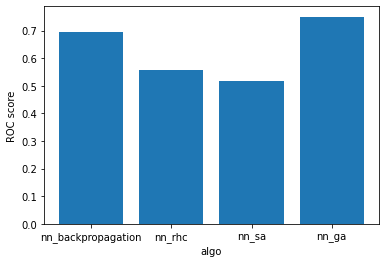

In [18]:
plt.bar(nn_performance['name'], nn_performance['test_roc'])
plt.xlabel("algo")
plt.ylabel("ROC score")
plt.show()

Text(0, 0.5, 'Run time')

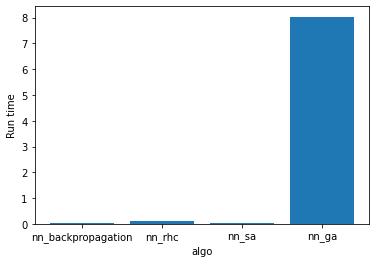

In [19]:
plt.bar(nn_performance['name'], nn_performance['run_time'])
plt.xlabel("algo")
plt.ylabel("Run time")